In [1]:
import numpy as np

from scipy.signal import fftconvolve
from scipy.interpolate import interp1d
from scipy.optimize import minimize

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import utils

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Data
---------
All data was extracted from Freeman & Fried (2011), Fig. 2

In [2]:
# Data extracted from Fig. 2 of Freeman & Fried (2011)
freeman = dict()

# From Figure 2A
freeman['norm_resp'] = dict()
freeman['norm_resp']['2'] = np.array([1.00000, 1.00000, 2.02247, 0.71475,
                                        2.98876, 0.68852, 3.95506, 0.65902,
                                        4.94382, 0.63934, 5.91011, 0.62623,
                                        6.89888, 0.62951, 7.88764, 0.62951,
                                        8.87640, 0.62623, 9.86517, 0.61311]).reshape((-1, 2))
freeman['norm_resp']['4'] = np.array([1.00000, 1.00000, 1.97753, 0.69836,
                                        2.98876, 0.60656, 3.95506, 0.58361,
                                        4.92135, 0.54098, 5.91011, 0.52787,
                                        6.89888, 0.53443, 7.93258, 0.52131,
                                        8.89888, 0.51148, 9.86517, 0.51148]).reshape((-1, 2))
freeman['norm_resp']['8'] = np.array([1.00000, 1.00000, 1.97753, 0.59672,
                                        3.03371, 0.52787, 3.97753, 0.47869,
                                        4.94382, 0.43607, 5.93258, 0.43279,
                                        6.92135, 0.40984, 7.88764, 0.37377,
                                        8.87640, 0.38689, 9.86517, 0.36721]).reshape((-1, 2))
freeman['norm_resp']['16'] = np.array([1.03371, 0.98361, 2.00000, 0.66557,
                                         2.98876, 0.48525, 3.97753, 0.42295,
                                         4.96629, 0.37049, 5.93258, 0.32787,
                                         6.92135, 0.31475, 7.93258, 0.29508,
                                         8.87640, 0.28197, 9.91011, 0.28197]).reshape((-1, 2))

# From Figure 8A
freeman['long_term'] = np.array([0.08333, 3.76415, 0.08333, 3.56604,
                                 0.05556, 3.24528, 0.08333, 2.96226,
                                 0.11111, 2.60377, 0.19444, 2.34906,
                                 0.19444, 2.11321, 0.27778, 1.83019,
                                 0.41667, 1.63208, 0.91667, 1.50000,
                                 2.08333, 1.43396, 3.72222, 1.36792,
                                 5.94444, 1.30189, 8.11111, 1.26415,
                                 10.55556, 1.18868, 12.83333, 1.13208,
                                 15.16667, 1.08491, 17.19444, 1.05660,
                                 18.50000, 1.07547]).reshape((-1, 2))

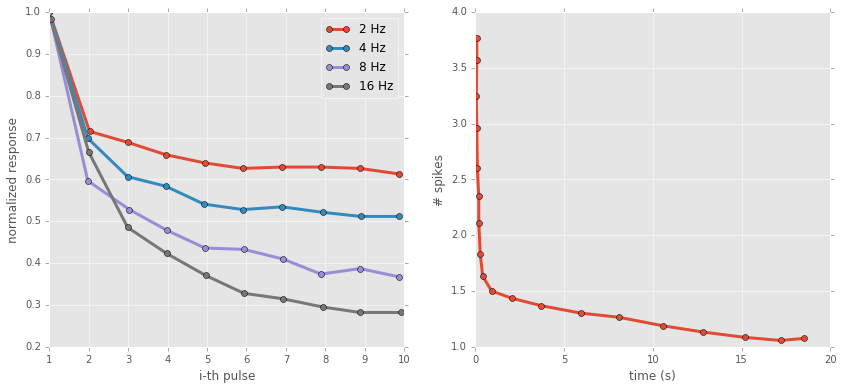

In [3]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
for cond in ['2', '4', '8', '16']:
    plt.plot(freeman['norm_resp'][cond][:, 0], freeman['norm_resp'][cond][:, 1], 'o-',
             linewidth=3, label=cond + ' Hz')
plt.xlabel('i-th pulse')
plt.ylabel('normalized response')
plt.legend()

plt.subplot(122)
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1], 'o-', linewidth=3)
plt.xlabel('time (s)')
plt.ylabel('# spikes')

In [4]:
# Data extracted from Fig. 1
cai2011 = dict()

cai2011['100'] = np.array([0.46257, 0.00105, 0.97908, 0.13688, 1.92488, 1.00413,
                           2.93725, 1.00626, 3.94948, 1.01050, 4.92435, 1.01255,
                           5.93659, 1.01679, 6.92409, 1.01676, 7.94909, 1.01681]).reshape((-1, 2))
cai2011['200'] = np.array([0.47507, 0.00108, 0.95816, 0.07157, 1.95514, 0.71998,
                           2.93725, 1.00626, 3.93698, 1.01047, 4.92448, 1.01045,
                           5.94922, 1.01471, 6.93646, 1.01889, 7.93672, 1.01468]).reshape((-1, 2))
cai2011['300'] = np.array([0.47507, 0.00108, 0.99671, 0.05481, 1.95487, 0.52419,
                           2.93225, 0.88625, 3.93856, 0.98521, 4.94948, 1.01050,
                           5.93672, 1.01468, 6.93672, 1.01468, 7.94909, 1.01681]).reshape((-1, 2))

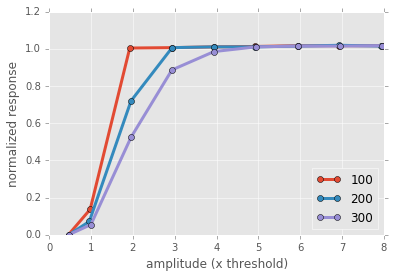

In [5]:
for cond in cai2011:
    plt.plot(cai2011[cond][:, 0], cai2011[cond][:, 1], 'o-', linewidth=3, label=cond)
plt.legend(loc='lower right')
plt.xlabel('amplitude (x threshold)')
plt.ylabel('normalized response')

# Model
-----------------

Following are all utily funcions used in this script.

In [6]:
class GanglionCell(object):
    def __init__(self, tsample, ca1_scale=1.0, ca1_tau=0.0191, ca2_scale=1.0, ca2_tau=14.0,
                 sig_a=2.0, sig_b=7.0):
        assert ca1_scale > 0
        assert ca2_scale > 0
        assert ca1_tau > 0
        assert ca2_tau >0
        self.ca1_tau = ca1_tau
        self.ca2_tau = ca2_tau
        self.ca1_scale = ca1_scale
        self.ca2_scale = ca2_scale
        self.tsample = tsample
        self.sig_a = sig_a
        self.sig_b = sig_b

        self.tau_nfl = 0.42 / 1000
        t = np.arange(0, 10 * self.tau_nfl, self.tsample)
        self.gamma_nfl = e2cm.gamma(1, self.tau_nfl, t)
        self.gamma_nfl /= np.trapz(self.gamma_nfl, dx=self.tsample)

        t = np.arange(0, 10 * self.ca1_tau, self.tsample)
        self.gamma_ca_fast = e2cm.gamma(1, self.ca1_tau, t)
        self.gamma_ca_fast /= np.trapz(self.gamma_ca_fast, dx=self.tsample)

#         t = np.arange(0, 10 * self.ca2_tau, self.tsample)
#         self.gamma_ca_slow = e2cm.gamma(1, self.ca2_tau, t)
#         self.gamma_ca_slow /= np.trapz(self.gamma_ca_slow, dx=self.tsample)

        
    def model_cascade(self, pt, dolayers=None, dojit=True):
        assert pt.tsample == self.tsample
        
        self.stim = pt
        self.ca_fast = pt.tsample * fftconvolve(np.abs(pt.data),
                                                  self.gamma_ca_fast, mode='full')[:pt.data.size]
#         self.ca_slow = pt.tsample * fftconvolve(np.abs(pt.data),
#                                                   self.gamma_ca_slow, mode='full')[:pt.data.size]

        self.r_impulse = pt.tsample * fftconvolve(pt.data, self.gamma_nfl)[:pt.data.size]
        
        self.r_adj = self.r_impulse - self.ca1_scale * self.ca_fast #- self.ca2_scale * self.ca_slow
        
        self.r_rgc = 100.0 / (1.0 + np.exp(-self.sig_a * self.r_adj + self.sig_b))
        
        return utils.TimeSeries(pt.tsample, self.r_rgc)

# Fit
----------

In [7]:
def run_freeman2011_exp0(model):
    pdur = 1.0 / 1000
    amp = 1.0
    num_pulses = 1
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp0 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=1, amp=amp, dur=0.1,
                                  pulse_dur=pdur, interphase_dur=0,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp0['gcr'] = gcr
    exp0['mov'] = mov
    exp0['resp'] = mov.data.max()
        
    return exp0

In [8]:
def run_freeman2011_exp1(model, freqs=[2, 4, 8, 16]):
    pdur = 1.0 / 1000
    amp = 2.0
    num_pulses = 10
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    for freq in freqs:
        cond = str(freq)
        exp1[cond] = dict()
        
        stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                      pulse_dur=pdur, interphase_dur=0,
                                      pulsetype='cathodicfirst',
                                      delay=20.0 / 1000)
        mov = gcr.model_cascade(stim)
        exp1[cond]['gcr'] = gcr
        exp1[cond]['mov'] = mov
        resp = np.squeeze(mov.data)
        freq_size = int(resp.size / float(num_pulses))
        peaks = []
        for f in range(num_pulses):
            slc = resp[f*freq_size: (f + 1) * freq_size]
            peaks.append(slc.max())

        exp1[cond]['resp'] = peaks
        exp1[cond]['norm_resp'] = peaks / (peaks[0] + np.finfo(float).eps)
        
    return exp1

In [9]:
def run_freeman2011_exp2(model):
    pdur = 1.0 / 1000
    amp = 2.0
    freq = 16.0
    num_pulses = 300
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp2 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=float(num_pulses) / freq,
                                  pulse_dur=pdur, interphase_dur=0,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp2['gcr'] = gcr
    exp2['mov'] = mov
    
    resp = np.squeeze(mov.data)
    freq_size = int(resp.size / float(num_pulses))
    peaks = []
    for f in range(num_pulses):
        slc = resp[f*freq_size: (f + 1) * freq_size]
        peaks.append(slc.max())

    exp2['t_resp'] = np.arange(num_pulses) / freq
    exp2['resp'] = peaks
    exp2['norm_resp'] = peaks / (peaks[0] + np.finfo(float).eps)
        
    return exp2

In [10]:
def run_cai2011_exp0(model):
    # Finding threshold
    freq = 10.0
    pdur = 0.2 / 1000
    idur = 10.0 / 1000
    amp = 1.0
    num_pulses = 1
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp0 = dict()
    stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.1,
                                  pulse_dur=pdur, interphase_dur=idur,
                                  pulsetype='cathodicfirst',
                                  delay=20.0 / 1000)
    mov = gcr.model_cascade(stim)
    exp0['gcr'] = gcr
    exp0['mov'] = mov
    exp0['resp'] = mov.data.max()
        
    return exp0

In [11]:
def run_cai2011_exp1(model, freqs=[100, 200, 300]):
    pdur = 0.2 / 1000
    
    gcr = model['gcr']
    tsample = gcr.tsample

    exp1 = dict()
    exp1['freqs'] = freqs
    exp1['amps'] = np.arange(9)
    for freq in freqs:
        cond = str(freq)
        exp1[cond] = dict()
        
        idur = 0.5 / freq
        
        resp = []
        for amp in exp1['amps']:
            stim = e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=0.5,
                                          pulse_dur=pdur, interphase_dur=idur,
                                          pulsetype='cathodicfirst',
                                          delay=0.0 / 1000)
            mov = gcr.model_cascade(stim)
            resp.append(np.squeeze(mov.data.max()))

        exp1[cond]['resp'] = np.array(resp)
        exp1[cond]['norm_resp'] = (np.array(resp) + np.finfo(float).eps) / 100.0
        
    return exp1

In [12]:
def mse_freeman2011_exp0(x):
    model = get_model(x)
    exp0 = run_freeman2011_exp0(model)
    
    mse = np.abs(exp0['resp'] - 1.0) ** 2
    # print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))

    return mse

In [13]:
def mse_freeman2011_exp1(x, freeman, freqs):
    model = get_model(x)
    exp1 = run_freeman2011_exp1(model, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = str(freq)
        mse += np.mean(np.abs(exp1[cond]['norm_resp'] - freeman['norm_resp'][cond][:, 1]) ** 2)
    
    # print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [14]:
def mse_freeman2011_exp2(x, freeman):
    model = get_model(x)
    exp2 = run_freeman2011_exp2(model)

    # Linear interpolation between data points
    f = interp1d(exp2['t_resp'], exp2['norm_resp'], fill_value='extrapolate')
    
    # Normalize Freeman response
    norm_freeman = freeman['long_term'][:, 1] / freeman['long_term'][0, 1]
    
    # Interpolate model at Freeman data points
    mse = np.mean(np.abs(norm_freeman - f(freeman['long_term'][:, 0])) ** 2)
    # print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [15]:
def mse_cai2011_exp0(x):
    model = get_model(x)
    exp0 = run_cai2011_exp0(model)
    
    mse = np.abs(exp0['resp'] - 1.0) ** 2
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))

    return mse

In [16]:
def mse_cai2011_exp1(x, cai2011, freqs):
    model = get_model(x)
    exp1 = run_cai2011_exp1(model, freqs)
    
    mse = 0
    for freq in exp1['freqs']:
        cond = str(freq)
        
        mse += np.mean(np.abs(exp1[cond]['norm_resp'] - cai2011[cond][:, 1]) ** 2)
    
#     print('%s: %.7f' % (str([('%.7f' % xx) for xx in x]), mse))
    return mse

In [17]:
def mse_all(x, freeman, freeman2011_exp1_freqs, cai2011, cai2011_exp1_freqs):
    mse = 0
    
    mse += mse_freeman2011_exp0(x)
    mse += mse_freeman2011_exp1(x, freeman, freeman2011_exp1_freqs)
    mse += mse_freeman2011_exp2(x, freeman)
    mse += mse_cai2011_exp0(x)
    mse += mse_cai2011_exp1(x, cai2011, cai2011_exp1_freqs)
    
    print('%s: %.9f' % (str([('%.9f' % xx) for xx in x]).strip("'"), mse))
    return mse

In [18]:
def get_model(x):
    tsample = 0.005 / 1000

    [k1, tau1, a, b] = x
    model = dict()
    
    # Stimulating electrode remained 25um above the inner limiting membrane
    model['implant'] = e2cm.ElectrodeArray('epiretinal', 40.0 / 2, -500, -500, 25.0)

    r_sampling = 100
    axon_lambda = 2 
    model['retina'] = e2cm.Retina(sampling=r_sampling, axon_lambda=axon_lambda, rot=0,
                                  xlo=model['implant'][0].x_center,
                                  xhi=model['implant'][0].x_center,
                                  ylo=model['implant'][0].y_center,
                                  yhi=model['implant'][0].y_center)

    model['gcr'] = GanglionCell(tsample, ca1_scale=k1, ca1_tau=tau1,# ca2_scale=k2, ca2_tau=tau2,
                                sig_a=a, sig_b=b)
    
    return model

In [19]:
freeman2011_exp1_freqs = [2, 4, 8, 16]
cai2011_exp1_freqs = [100, 200, 300]

In [20]:
res = minimize(mse_all, [18.32, 0.164, 3.0, 8.0], args=(freeman, freeman2011_exp1_freqs,
                                                                    cai2011, cai2011_exp1_freqs),
               method='L-BFGS-B', bounds=[(0.1, 200.0), (10.0/1000, 500.0/1000),
                                          (-10.0, 10.0), (0.01, 10.0)])

['18.320000000', '0.164000000', '3.000000000', '8.000000000']: 3.451624735
['18.320000010', '0.164000000', '3.000000000', '8.000000000']: 3.451624735
['18.320000000', '0.164000010', '3.000000000', '8.000000000']: 3.451624691
['18.320000000', '0.164000000', '3.000000010', '8.000000000']: 3.451624726
['18.320000000', '0.164000000', '3.000000000', '8.000000010']: 3.451624742
['18.278994756', '0.500000000', '3.818733747', '7.216352453']: 1.576123378
['18.278994766', '0.500000000', '3.818733747', '7.216352453']: 1.576123378
['18.278994756', '0.500000010', '3.818733747', '7.216352453']: 1.576123377
['18.278994756', '0.500000000', '3.818733757', '7.216352453']: 1.576123378
['18.278994756', '0.500000000', '3.818733747', '7.216352463']: 1.576123378
['18.278495152', '0.500000000', '3.811134016', '7.226538475']: 1.576388105
['18.278495162', '0.500000000', '3.811134016', '7.226538475']: 1.576388105
['18.278495152', '0.500000010', '3.811134016', '7.226538475']: 1.576388103
['18.278495152', '0.50000

# Plot
----------

In [21]:
print(res)

      fun: 1.5416347407660729
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  6.66133815e-08,  -6.04149397e-02,  -9.10382880e-07,
         1.22124533e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 145
      nit: 20
   status: 0
  success: True
        x: array([ 12.51140561,   0.5       ,   5.45466001,   8.65965782])


In [22]:
test_freqs = [2, 4, 8, 16]
model = get_model(res.x)
exp1 = run_freeman2011_exp1(model, test_freqs)

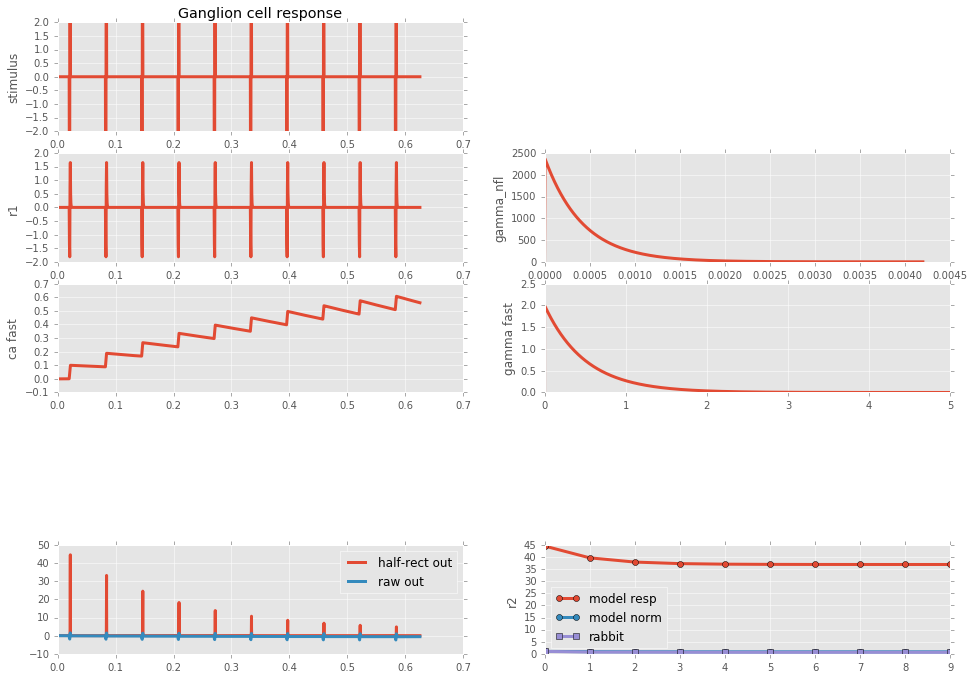

In [23]:
cond = str(test_freqs[0])

gcr = exp1[cond]['gcr']
tstim = np.arange(gcr.stim.data.size) * gcr.stim.tsample

plt.figure(figsize=(16, 16))
freq = 8.0

plt.subplot(721)
plt.plot(tstim, gcr.stim.data, linewidth=3)
plt.title('Ganglion cell response')
plt.ylabel('stimulus')

# Fast response
plt.subplot(723)
plt.plot(tstim, gcr.r_impulse, linewidth=3)
plt.ylabel('r1')

plt.subplot(724)
tgamma = np.arange(gcr.gamma_nfl.size) * gcr.stim.tsample
plt.plot(tgamma, gcr.gamma_nfl, linewidth=3)
plt.ylabel('gamma_nfl')

# Fast desensitization
plt.subplot(725)
plt.plot(tstim, gcr.ca_fast * gcr.ca1_scale, linewidth=3)
plt.ylabel('ca fast')
plt.subplot(726)
tgamma = np.arange(gcr.gamma_ca_fast.size) * gcr.stim.tsample
plt.plot(tgamma, gcr.gamma_ca_fast, linewidth=3)
plt.ylabel('gamma fast')

# Slow desensitization
if hasattr(gcr, 'ca_slow'):
    plt.subplot(727)
    plt.plot(tstim, gcr.ca_slow * gcr.ca2_scale, linewidth=3)
    plt.ylabel('ca slow')
    plt.subplot(728)
    tgamma = np.arange(gcr.gamma_ca_slow.size) * gcr.stim.tsample
    plt.plot(tgamma, gcr.gamma_ca_slow, linewidth=3)
    plt.ylabel('gamma slow')

plt.subplot(729)
plt.plot(tstim, gcr.r_rgc, linewidth=3, label='half-rect out')
plt.plot(tstim, gcr.r_adj, linewidth=3, label='raw out')
plt.legend()

plt.subplot(7,2,10)
plt.plot(exp1[cond]['resp'], 'o-', linewidth=3, label='model resp')
plt.plot(exp1[cond]['norm_resp'], 'o-', linewidth=3, label='model norm')
plt.plot(freeman['norm_resp'][cond][:, 1], 's-', linewidth=3, label='rabbit')
plt.ylabel('r2')
plt.legend(loc='best')

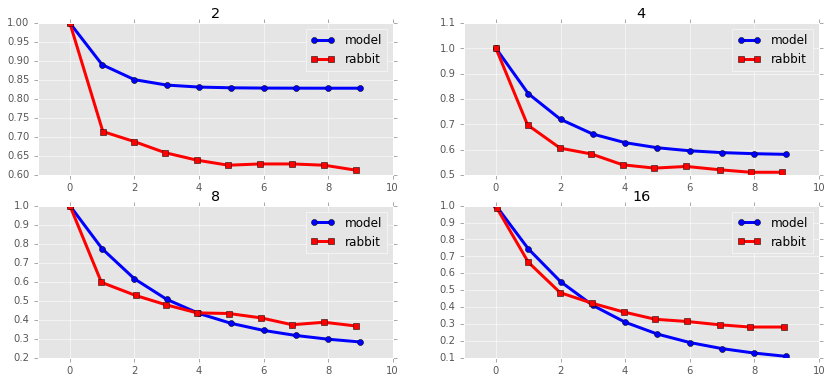

In [24]:
num_cols = np.floor(np.sqrt(len(test_freqs)))
num_rows = np.ceil(len(test_freqs) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate(test_freqs):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    if 'resp' in exp1[freqstr]:
        plt.plot(exp1[freqstr]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if freqstr in freeman['norm_resp']:
        plt.plot(freeman['norm_resp'][freqstr][:, 0] - 1,
                 freeman['norm_resp'][freqstr][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(freqstr)
#     plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')

In [25]:
exp2 = run_freeman2011_exp2(model)

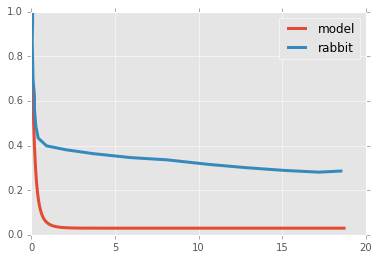

In [26]:
plt.plot(exp2['t_resp'], exp2['norm_resp'], linewidth=3, label='model')
plt.plot(freeman['long_term'][:, 0], freeman['long_term'][:, 1] / freeman['long_term'][0, 1], linewidth=3, label='rabbit')
plt.legend()

In [27]:
test_freqs = [100, 200, 300]
exp1 = run_cai2011_exp1(model, test_freqs)

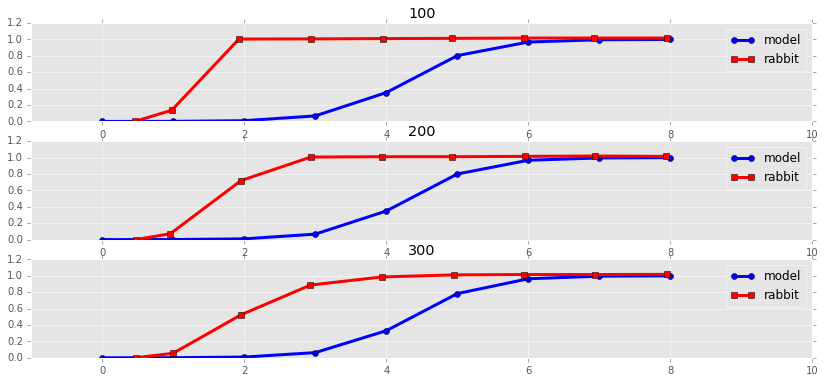

In [28]:
num_cols = np.floor(np.sqrt(len(test_freqs)))
num_rows = np.ceil(len(test_freqs) / num_cols)
plt.figure(figsize=(14, 6))
for i, freq in enumerate(test_freqs):
    freqstr = str(freq)
    plt.subplot(num_rows, num_cols, i + 1)
    if 'norm_resp' in exp1[freqstr]:
        plt.plot(exp1[freqstr]['norm_resp'], 'o-b',
                 linewidth=3, label='model')
    if freqstr in cai2011:
        plt.plot(cai2011[freqstr][:, 0],
                 cai2011[freqstr][:, 1], 's-r',
                 linewidth=3, label='rabbit')
    plt.title(freqstr)
#     plt.ylim(0, 1.2)
    plt.xlim(-1, 10)
    plt.legend(loc='best')